## Goal:
Search for anomalies in Store Friendly data with unsupervised learning (no labeled data).
## References:
**Methods and categories of anomaly detection:** https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/

**Example of IoT use case and intelligent combination of methods:** https://journalofbigdata.springeropen.com/articles/10.1186/s40537-014-0011-y

**Examples of undupervised anomaly detection in python:**https://github.com/Vicam/Unsupervised_Anomaly_Detection


In [62]:
# libraries, imports
%matplotlib inline

import pandas as pd
import numpy as np
import custom_function as cf

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from fbprophet import Prophet


# 1 Data
## 1.1 Extract data

Stored in two seperate CSVs

In [63]:
df_temp1 = pd.read_csv("data/storage_temp_10min.csv")
df_temp2 = pd.read_csv("data/storage_temp_10min_2.csv")



## 1.2 Check the data


In [64]:
print('Loaded:')
print(df_temp1.info())
print(df_temp2.info())



Loaded:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19890 entries, 0 to 19889
Data columns (total 2 columns):
timestamp       19890 non-null object
Self Storage    19890 non-null float64
dtypes: float64(1), object(1)
memory usage: 310.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30770 entries, 0 to 30769
Data columns (total 2 columns):
timestamp       30770 non-null object
Self Storage    30770 non-null float64
dtypes: float64(1), object(1)
memory usage: 480.9+ KB
None


## 1.3 Format the data and graph the data

change the type of timestamp column for plotting

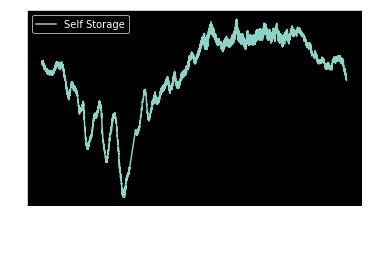

In [65]:
df_temp1[timeStamp] = pd.to_datetime(df_temp1[timeStamp])
df_temp2[timeStamp] = pd.to_datetime(df_temp2[timeStamp])


#combine data into one data frame
frames = [df_temp1, df_temp2]
df_temp = pd.concat(frames).reset_index(drop=True)

# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df_temp[dataValues] = (df_temp[dataValues] - 32) * 5/9

# plot the data
df_temp.plot(x=timeStamp, y=dataValues)




## 1.4 Important Features
What is important to understand fluctuations? Open hours? Weekdays? Weekends?
Storefriendly is always open, but seasons might be useful to understand temperature


extract info for the months

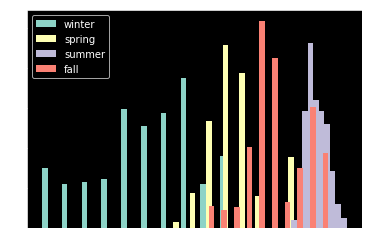

In [66]:
df_temp['month'] = df_temp[timeStamp].dt.month
#translate that into seasons
df_temp['season'] = ((np.floor(df_temp['month']/3))%4).astype(int)

seasonNames= ["winter","spring","summer","fall"]

# histogram of season values
fig, ax = plt.subplots()
for i in range(0,4):
    df_season=df_temp.loc[df_temp['season']==i, dataValues]
    height, bins = np.histogram(df_season)
    ax.bar(bins[:-1], height*100/df_season.count(), width= .25, label= seasonNames[i])


plt.legend()
plt.show()

It seems that Season is a useful feature, as temperatures of different seasons are grouped together.

Enconde season as a feature vector. We will add 4 columns to the dataframe for the seasons
if the datapoint is in the season then 1 else 0


In [67]:
for j in range(0,4):
    df_temp[seasonNames[j]]= (df_temp['season']==j).astype(int)


# 2 Models
## 2.1 Cluster only
#### Use for collective anomalies (unordered).

K-means is a simple unsupervised machine learning algorithm that groups a dataset into a user-specified number (k) of clusters.
The algorithm is somewhat naive--it clusters the data into k clusters, even if k is not the right number of clusters to use.
Therefore, when using k-means clustering, users need some way to determine whether they are using the right number of clusters.

Some algorithms require us to make a guess as to the precentage of outliers

In [68]:
outliers_fraction = 0.03

# Take the useful features [markdown]
data = df_temp[[dataValues, 'month', 'winter', 'spring', 'summer', 'fall']]

#Many ML algorithms assume data in a standard distribution, so we scale the vectors
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# Dimensionality reduction on to a 2D space
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)


/home/beau/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/beau/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


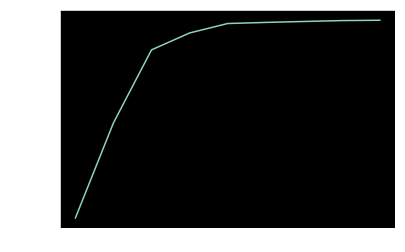

In [69]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 10)
km = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [km[i].fit(data).score(data) for i in range(len(km))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()


In [70]:
#It seems that 5 clusters is the way to go! 
#Perform k-means clustering on our 2 features
#Add to central data frame

kmClusterSize=4

df_temp['principal_feature1'] = data[0]
df_temp['principal_feature2'] = data[1]
df_temp['cluster'] = km[kmClusterSize].predict(data)
df_temp['cluster'].value_counts()


2    16875
4    12434
1    10769
3     6267
0     4315
Name: cluster, dtype: int64

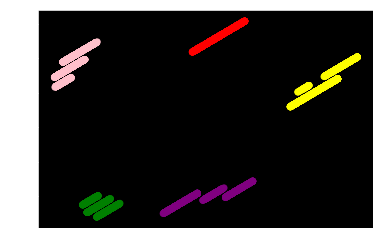

/home/beau/Energybox/eb_anomalydetection/custom_function.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  distance.set_value(i, np.linalg.norm(Xa-Xb))


In [71]:

#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'purple', 2:'pink', 3:'yellow', 4: 'green'}
ax.scatter(df_temp['principal_feature1'], df_temp['principal_feature2'], c=df_temp["cluster"].apply(lambda x: colors[x]))
plt.show()

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = cf.getDistanceByPoint(data, km[kmClusterSize])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df_temp['anomaly21'] = (distance >= threshold).astype(int)


Visualizing in cluster view

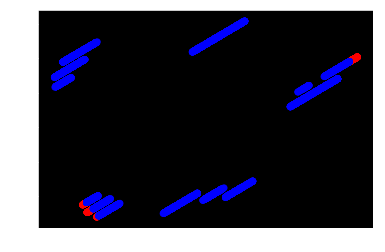

In [72]:
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}

ax.scatter(df_temp['principal_feature1'], df_temp['principal_feature2'], c=df_temp["anomaly21"].apply(lambda x: colors[x]))
plt.show()


Let's visualize the tagged anomaly points throughout time

represent time as an int to plot easily

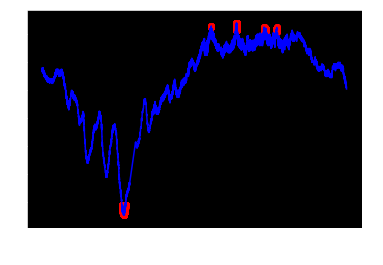

In [73]:
df_temp['time_epoch'] = (df_temp[timeStamp].astype(np.int64)/100000000000).astype(np.int64)

fig, ax = plt.subplots()

a = df_temp.loc[df_temp['anomaly21'] == 1, ['time_epoch', dataValues]] #anomaly

ax.plot(df_temp['time_epoch'], df_temp[dataValues], color='blue')
ax.scatter(a['time_epoch'],a[dataValues], color='red')
plt.show()


Good at catching obvious anomalies in context of the entire data set


## 2.2 Clusters + Gaussian
#### Use for contextual data and collective anomalies (unordered).
We will take the clusters formed by the previous model but instead of computing distance we will use a
Elliptic Envelope and tag points outside as anomolies.


Use the kmeans clusters in the previous section as categories
plot the temperature repartition by category


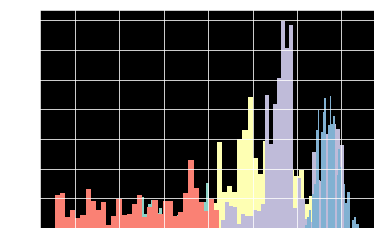

In [74]:
df_classes=[]
for i in range(0,kmClusterSize+1):
    df_class= df_temp.loc[df_temp['cluster'] == i, dataValues]
    #visualize the cluster
    df_class.hist(bins=32)
    #add
    df_classes.append(df_class)


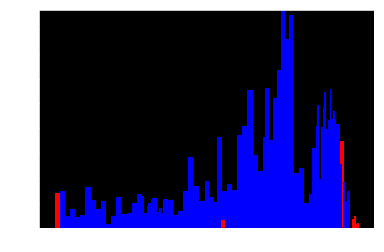

In [75]:
# apply ellipticEnvelope(gaussian distribution) at each categories

df_classesAnom=[]
fig, ax = plt.subplots()
for c in df_classes:
    envelope =  EllipticEnvelope(contamination = outliers_fraction) 
    X_train = c.values.reshape(-1,1)
    envelope.fit(X_train)
    c = pd.DataFrame(c)
    c['deviation'] = envelope.decision_function(X_train)
    c['anomaly'] = envelope.predict(X_train)
    a0 = c.loc[c['anomaly'] == 1, dataValues]
    b0 = c.loc[c['anomaly'] == -1, dataValues]
    ax.hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'])
    df_classesAnom.append(c)



In [76]:
# add the data to the main 
df_class=pd.concat(df_classesAnom)
df_temp['anomaly22'] = df_class['anomaly']
df_temp['anomaly22'] = np.array(df_temp['anomaly22'] == -1).astype(int) 


Let's visualize the tagged anomaly points throughout time

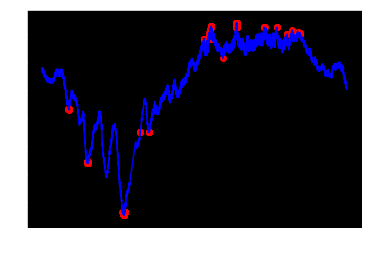

In [77]:
fig, ax = plt.subplots()

a = df_temp.loc[df_temp['anomaly22'] == 1, ('time_epoch', dataValues)] #anomaly

ax.plot(df_temp['time_epoch'], df_temp[dataValues], color='blue')
ax.scatter(a['time_epoch'],a[dataValues], color='red')
plt.show()

Good at catching paticular spikes within seasonal behavior.

## 2.4 Markov chains
#### Use for  sequential anomalies (ordered)
We need to discretize the data points in defined states for the Markov Chain.
The Markov chain will calculate the probability of a paticular sequence of these states.
For this example we will take dataValues temperature and define 5 levels states depending temperature level.
Definition of the states by temperature level:

In [78]:
vL = (df_temp[dataValues] <=18).astype(int)
L= ((df_temp[dataValues] > 18) & (df_temp[dataValues]<=21)).astype(int)
A = ((df_temp[dataValues] > 21) & (df_temp[dataValues]<=24)).astype(int)
H = ((df_temp[dataValues] > 24) & (df_temp[dataValues]<=27)).astype(int)
vH = (df_temp[dataValues] >27).astype(int)

#Parameters for our Markov Model 
df_mm = vL + 2*L + 3*A + 4*H + 5*vH

#size of the pattern window
sequenceSize = 10
#Probability of anomaly
probAnom= .1

# getting the anomaly labels for our dataset (evaluating sequence of 5 values and anomaly = less than 20% probable)
df_anomaly = cf.markovAnomaly(df_mm, sequenceSize, probAnom)
df_anomaly = pd.Series(df_anomaly)



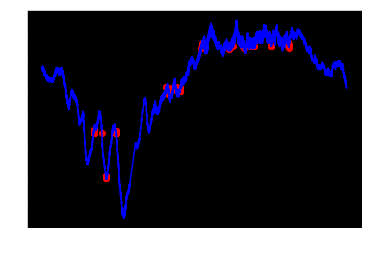

In [79]:
# add the data to the main 
df_temp['anomaly23'] = df_anomaly

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df_temp.loc[df_temp['anomaly23'] == 1, ('time_epoch', dataValues)] #anomaly

ax.plot(df_temp['time_epoch'], df_temp[dataValues], color='blue')
ax.scatter(a['time_epoch'],a[dataValues], color='red')
plt.show()



It seems that the Markov Model is good at detecting abnormalities in the sequence/cycling of temperature.
This could be very good for our purposes, but it is harder to test for meaningful anomalies.

